In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241204_215221_clip_349.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241204_195819_clip_330.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241204_195819_clip_320.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241205_104819_clip_75.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241205_104819_clip_71.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241204_184453_clip_247.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241204_191217_clip_143.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/20241204_215221_clip_333.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips/VID_20241204_205723_clip_20.mp4
/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clip

Epoch 1/20


I0000 00:00:1733667207.155103   13687 service.cc:145] XLA service 0x7c3d44044de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733667207.155165   13687 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733667212.905668   13687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 ━━━━━━━━━━━━━━━━━━━━ 124s 209ms/step - loss: 0.0222 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 2/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0121 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 3/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0111 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 4/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0103 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 5/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0107 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 6/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0097 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 7/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0102 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 8/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0101 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 9/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - loss: 0.0097 - val_loss: 0.0099 - learnin

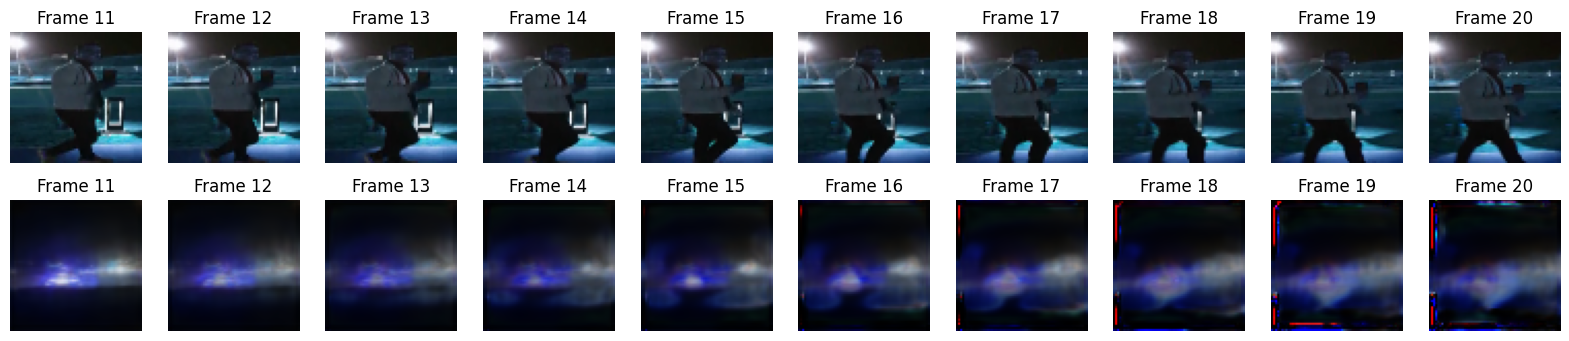

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import cv2

# Define a custom dataset loader to extract frames from videos
class VideoDataset:
    def __init__(self, video_dir, frame_size=(64, 64)):
        self.video_dir = video_dir
        self.frame_size = frame_size
        self.videos = [os.path.join(video_dir, file) for file in os.listdir(video_dir) if file.endswith('.mp4')]

    def load_data(self):
        sequences = []
        for video_path in self.videos:
            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, self.frame_size)
                frames.append(frame)
            cap.release()
            if len(frames) >= 20:  # Ensure minimum sequence length
                sequences.append(np.array(frames[:20]))
        return np.array(sequences)

# Load video data
video_dir = "/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips"
frame_size = (64, 64)
dataset = VideoDataset(video_dir, frame_size=frame_size)
data = dataset.load_data()

# Normalize and split the dataset into train and validation sets
data = data / 255.0
x_train, x_val = train_test_split(data, test_size=0.2, random_state=42)

# Prepare inputs and targets
x_train, y_train = x_train[:, :10], x_train[:, 10:]
x_val, y_val = x_val[:, :10], x_val[:, 10:]

# Define the ConvLSTM model
inp = layers.Input(shape=(None, *x_train.shape[2:]))
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = models.Model(inp, x)
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
)

# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Train the model
batch_size = 5
epochs = 20
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


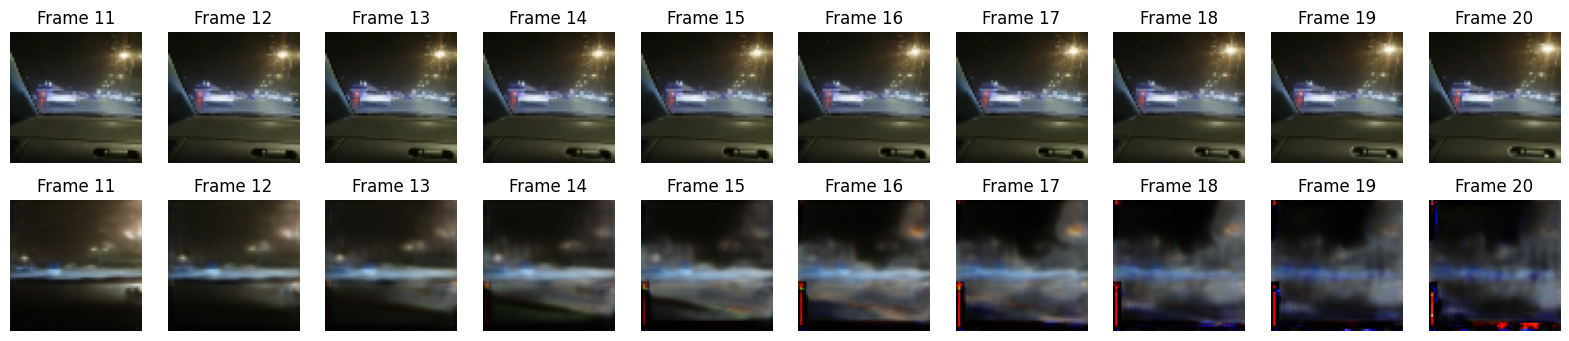

Predicted video saved to predicted_video.mp4


In [4]:
# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_path, fourcc, 5, frame_size[::-1])

for frame in (new_frames * 255).astype(np.uint8):
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

video_writer.release()
print(f"Predicted video saved to {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


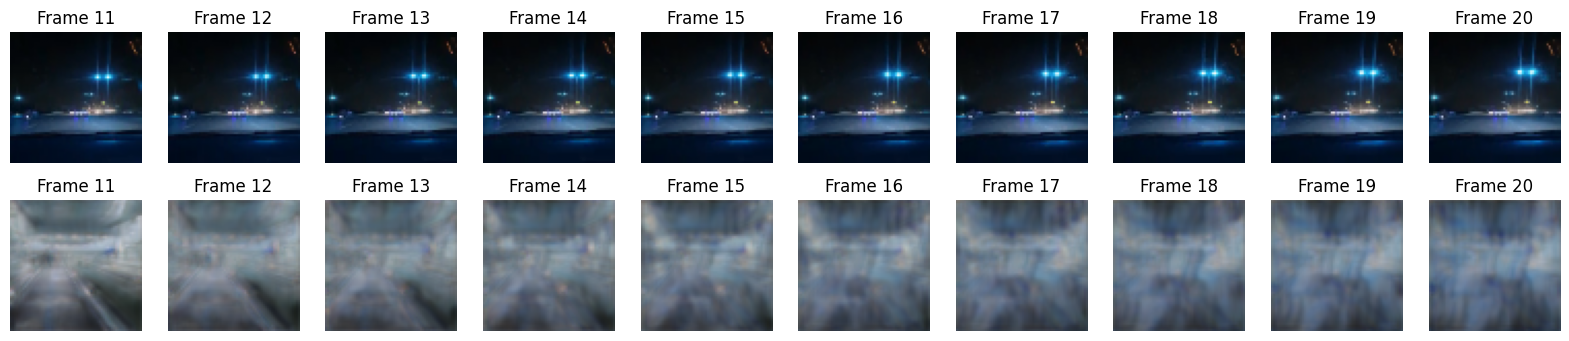

Predicted video saved to predicted_video.mp4


In [5]:
# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_path, fourcc, 5, frame_size[::-1])

for frame in (new_frames * 255).astype(np.uint8):
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

video_writer.release()
print(f"Predicted video saved to {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


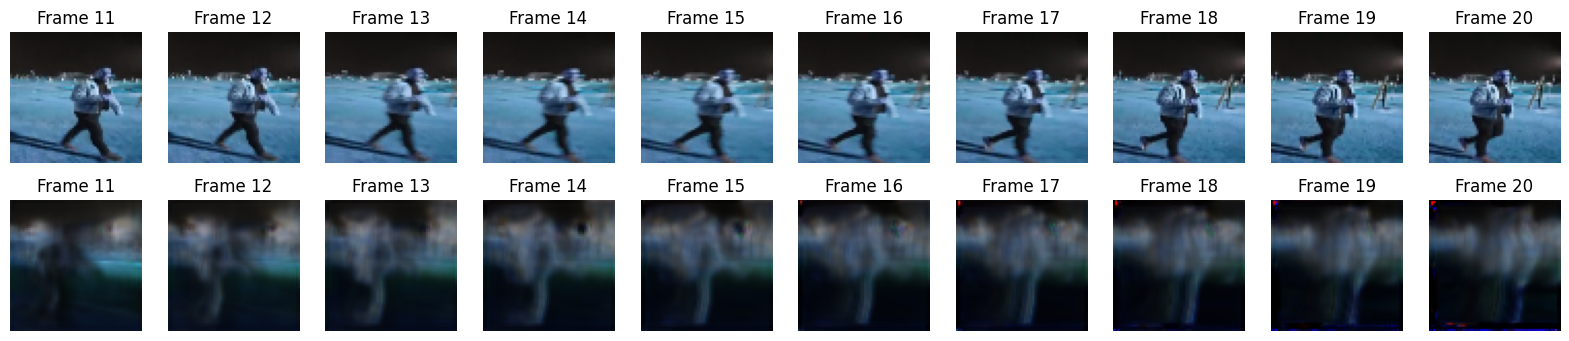

Predicted video saved to predicted_video.mp4


In [7]:
# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_path, fourcc, 5, frame_size[::-1])

for frame in (new_frames * 255).astype(np.uint8):
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

video_writer.release()
print(f"Predicted video saved to {output_path}")


In [9]:
# Save the trained model weights
weights_path = "model_weights.weights.h5"
model.save_weights(weights_path)
print(f"Model weights saved to {weights_path}")


Model weights saved to model_weights.weights.h5


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import cv2

# Define a custom dataset loader to extract frames from videos
class VideoDataset:
    def __init__(self, video_dir, frame_size=(64, 64)):
        self.video_dir = video_dir
        self.frame_size = frame_size
        self.videos = [os.path.join(video_dir, file) for file in os.listdir(video_dir) if file.endswith('.mp4')]

    def load_data(self):
        sequences = []
        for video_path in self.videos:
            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, self.frame_size)
                frames.append(frame)
            cap.release()
            if len(frames) >= 20:  # Ensure minimum sequence length
                sequences.append(np.array(frames[:20]))
        return np.array(sequences)

# Load video data
video_dir = "/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips"
frame_size = (64, 64)
dataset = VideoDataset(video_dir, frame_size=frame_size)
data = dataset.load_data()

# Normalize and split the dataset into train and validation sets
data = data / 255.0
x_train, x_val = train_test_split(data, test_size=0.2, random_state=42)

# Prepare inputs and targets
x_train, y_train = x_train[:, :10], x_train[:, 10:]
x_val, y_val = x_val[:, :10], x_val[:, 10:]

In [4]:
print("done")

done


DEEEP MODELS

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Reshape
from tensorflow.keras.callbacks import TensorBoard

# Define the ConvLSTM model with 18 layers
print("Building the ConvLSTM model...")
modelLarger = Sequential()

sequence_length = 20  # Adjust as needed for your dataset
input_height, input_width, input_channels = 64, 64, 3  # Match your dataset

# Input layer
modelLarger.add(ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    input_shape=(sequence_length, input_height, input_width, input_channels)
))
modelLarger.add(BatchNormalization())

# Add 8 more ConvLSTM2D layers (filters=64, kernel_size=(3, 3))
for _ in range(8):
    modelLarger.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True))
    modelLarger.add(BatchNormalization())

# Add 5 ConvLSTM2D layers (filters=32, kernel_size=(3, 3))
for _ in range(5):
    modelLarger.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True))
    modelLarger.add(BatchNormalization())

# Final ConvLSTM2D layer before reshaping
modelLarger.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False))
modelLarger.add(BatchNormalization())

# Reshape to add the depth dimension for Conv3D
modelLarger.add(Reshape((1, input_height, input_width, 32)))  # Adding temporal depth = 1

# Final Conv3D layer for output
modelLarger.add(Conv3D(filters=3, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))

# Compile the model
modelLarger.compile(optimizer='adam', loss='mse')
print(modelLarger.summary())

# Train the model
print("Starting training...")
tensorboard = TensorBoard(log_dir="logs")
modelLarger.fit(x_train, y_train, batch_size=4, epochs=10, validation_split=0.2, callbacks=[tensorboard])


Building the ConvLSTM model...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 64, 64, 64) │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 20, 64, 64, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 20, 64, 64, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, 20, 64, 64, 32) │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 20, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 3,001,635 (11.45 MB)

 Trainable params: 3,000,099 (11.44 MB)

 Non-trainable params: 1,536 (6.00 KB)

None
Starting training...
Epoch 1/10


I0000 00:00:1733672903.771710   13687 service.cc:145] XLA service 0x5a59f11d7ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733672903.771761   13687 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733672918.145361   13687 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 136 bytes spill stores, 136 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 436 bytes spill stores, 472 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1733672918.187803   13687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


544/545 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 0.0409

I0000 00:00:1733673201.963196   13687 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 136 bytes spill stores, 136 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 436 bytes spill stores, 472 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads



545/545 ━━━━━━━━━━━━━━━━━━━━ 346s 564ms/step - loss: 0.0408 - val_loss: 0.0158
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 288s 528ms/step - loss: 0.0218 - val_loss: 0.0305
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 288s 528ms/step - loss: 0.0161 - val_loss: 0.0484
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 288s 528ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 288s 528ms/step - loss: 0.0114 - val_loss: 0.0137
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 287s 527ms/step - loss: 0.0105 - val_loss: 0.0118
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 287s 527ms/step - loss: 0.0097 - val_loss: 0.0088
Epoch 8/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 287s 527ms/step - loss: 0.0089 - val_loss: 0.0173
Epoch 9/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 287s 527ms/step - loss: 0.0091 - val_loss: 0.0194
Epoch 10/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 287s 527ms/step - loss: 0.0092 - val_loss: 0.0253


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


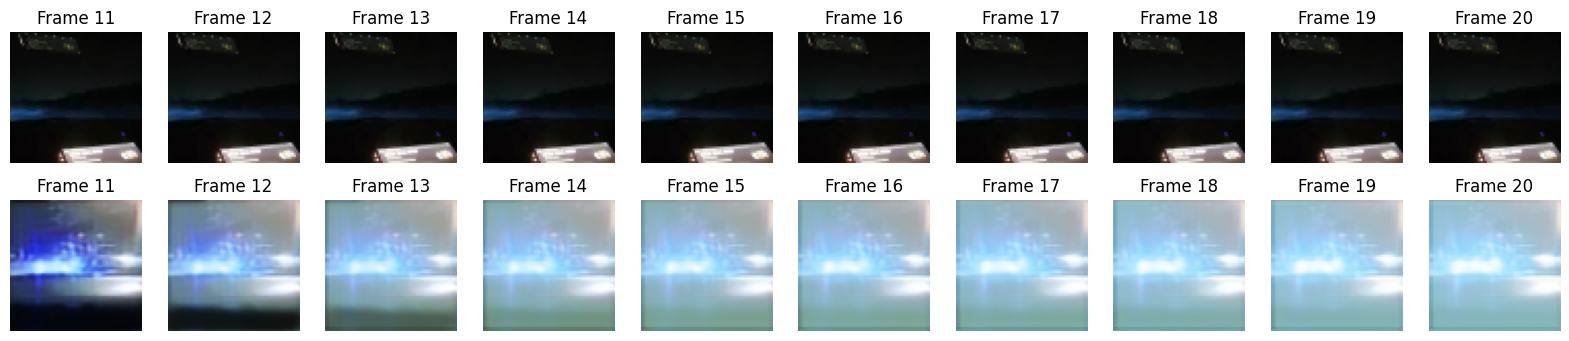

Predicted video saved to predicted_video.mp4


In [7]:
# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = modelLarger.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_path, fourcc, 5, frame_size[::-1])

for frame in (new_frames * 255).astype(np.uint8):
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

video_writer.release()
print(f"Predicted video saved to {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


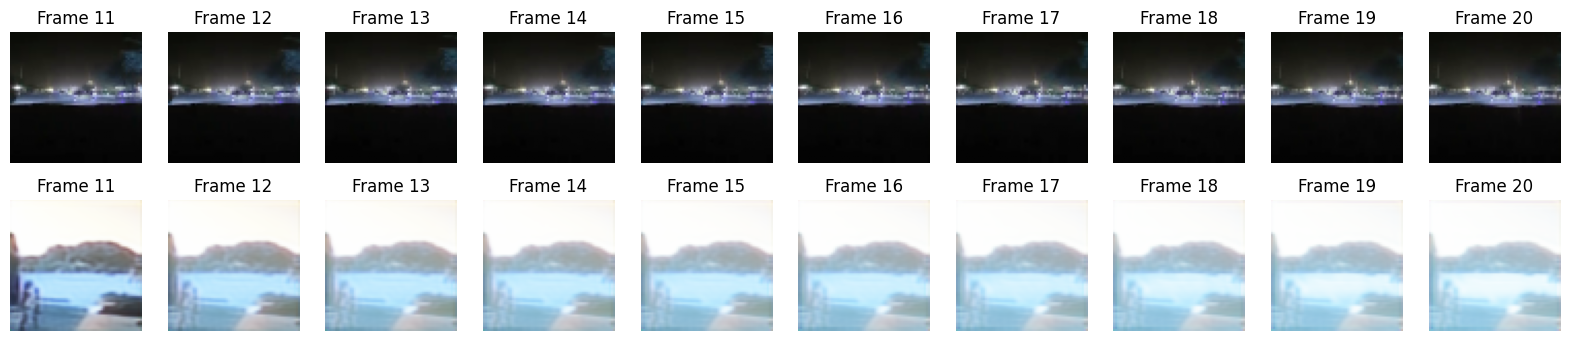

Predicted video saved to predicted_video.mp4


In [9]:
# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = modelLarger.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_path, fourcc, 10, frame_size[::-1])

for frame in (new_frames * 255).astype(np.uint8):
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

video_writer.release()
print(f"Predicted video saved to {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


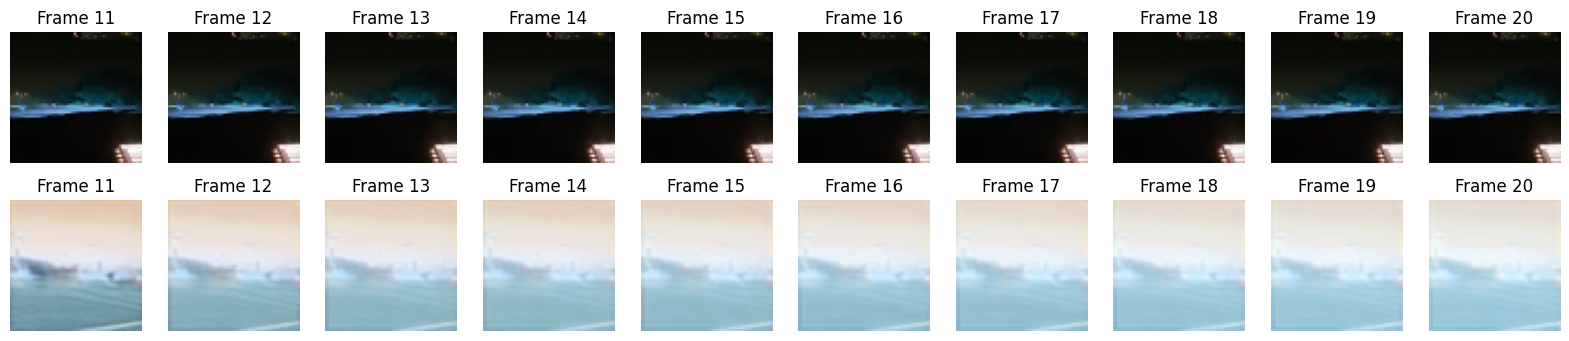

Predicted video saved to predicted_video.mp4


In [10]:
# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = modelLarger.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
frame_rate = 2  # 2 frames per second for a 5-second video
frame_size = (new_frames.shape[2], new_frames.shape[1])
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, frame_size)

for frame in (new_frames * 255).astype(np.uint8):
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

video_writer.release()
print(f"Predicted video saved to {output_path}")


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import cv2

# Define a custom dataset loader to extract frames from videos
class VideoDataset:
    def __init__(self, video_dir, frame_size=(64, 64)):
        self.video_dir = video_dir
        self.frame_size = frame_size
        self.videos = [os.path.join(video_dir, file) for file in os.listdir(video_dir) if file.endswith('.mp4')]

    def load_data(self):
        sequences = []
        for video_path in self.videos:
            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, self.frame_size)
                frames.append(frame)
            cap.release()
            if len(frames) >= 20:  # Ensure minimum sequence length
                sequences.append(np.array(frames[:20]))
        return np.array(sequences)

# Load video data
video_dir = "/kaggle/input/cv-dataset/resized_clips-20241208T093932Z-001/resized_clips"
frame_size = (64, 64)
dataset = VideoDataset(video_dir, frame_size=frame_size)
data = dataset.load_data()

# Normalize and split the dataset into train and validation sets
data = data / 255.0
x_train, x_val = train_test_split(data, test_size=0.2, random_state=42)

# Prepare inputs and targets
x_train, y_train = x_train[:, :10], x_train[:, 10:]
x_val, y_val = x_val[:, :10], x_val[:, 10:]

In [3]:
print("hello")

hello


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 64, 64,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 64, 64,   │       429,056 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 64, 64,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 64, 64,   │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 64, 64,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 64, 64,   │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 64, 64,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, None, 64, 64,   │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 64, 64,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, None, 64, 64,   │       885,248 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, 64, 64,   │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, None, 64, 64,   │     1,180,160 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, None, 64, 64,   │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, None, 64, 64,   │     1,180,160 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, 64, 64,   │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, None, 64, 64,   │     1,180,160 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, None, 64, 64,   │           51

 Total params: 9,176,899 (35.01 MB)

 Trainable params: 9,174,339 (35.00 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/20


I0000 00:00:1733676978.924455   13687 service.cc:145] XLA service 0x592392607400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733676978.924518   13687 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733676994.715746   13687 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 136 bytes spill stores, 136 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 136 bytes spill stores, 136 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm20_rcp_rn_f32_slowpath', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1733676994.755838   13687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


544/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0472

I0000 00:00:1733677608.964283   13685 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 136 bytes spill stores, 136 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 136 bytes spill stores, 136 bytes spill loads



545/545 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - loss: 0.0472 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 2/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0403 - val_loss: 0.0980 - learning_rate: 0.0010
Epoch 3/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0274 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 4/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0248 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 5/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0221 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 6/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0207 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 7/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0216 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 8/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0227 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 9/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - loss: 0.0236 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 10/20


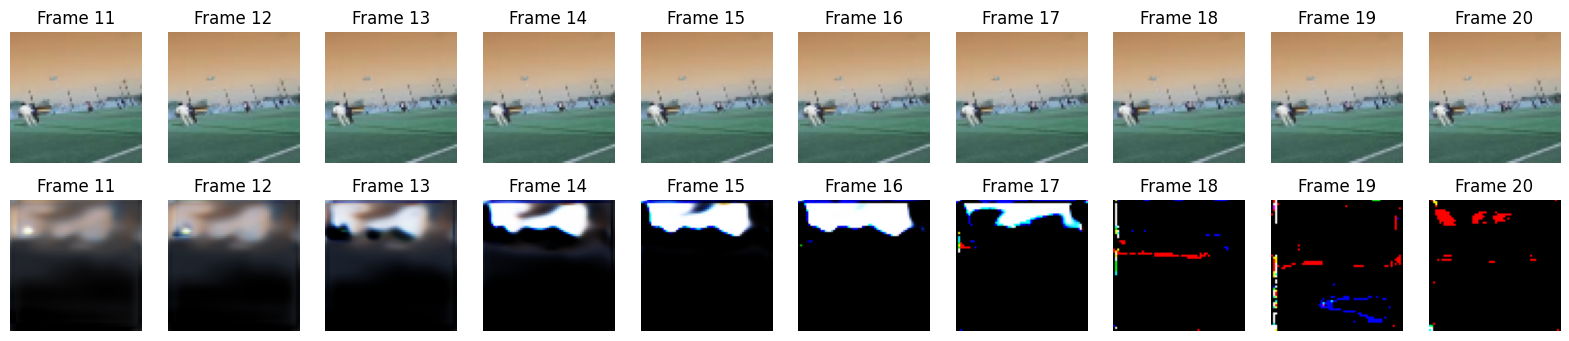

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import cv2

# Define input shape
conlstmModel3 = layers.Input(shape=(None, *x_train.shape[2:]))

# Layer 1
x = layers.ConvLSTM2D(
    filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu"
)(conlstmModel3)
x = layers.BatchNormalization()(x)

# Layers 2-4
for _ in range(3):
    x = layers.ConvLSTM2D(
        filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)

# Layers 5-7
for _ in range(3):
    x = layers.ConvLSTM2D(
        filters=128, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)

# Layers 8-10
for _ in range(3):
    x = layers.ConvLSTM2D(
        filters=128, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)

# Layers 11-13
for _ in range(3):
    x = layers.ConvLSTM2D(
        filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)

# Layer 14
x = layers.ConvLSTM2D(
    filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu"
)(x)
x = layers.BatchNormalization()(x)

# Layer 15 (final Conv3D layer for output)
x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Build and compile model
model = models.Model(conlstmModel3, x)
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
)

# Summary of the model
model.summary()

# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Train the model
batch_size = 5
epochs = 20
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

# Visualize predictions
example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
original_frames = y_val[np.random.choice(range(len(y_val)), size=1)[0]]

frames = example
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

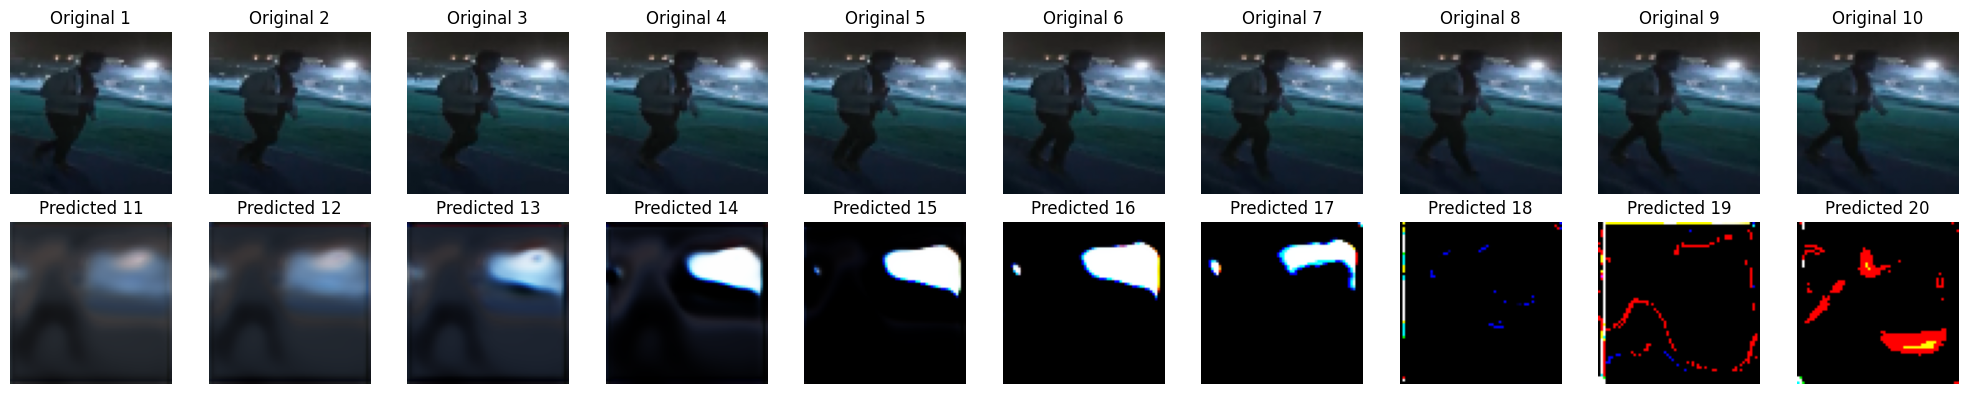

Predicted video saved to predicted_video.mp4


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Visualize predictions
example_idx = np.random.choice(range(len(x_val)), size=1)[0]
example = x_val[example_idx]  # Select a random example from x_val
original_frames = y_val[example_idx]  # Corresponding ground truth frames

# Generate predicted frames
frames = example.copy()  # Start with the selected example
predicted_frames = []

for _ in range(30):  # Predict 10 future frames
    new_prediction = model.predict(np.expand_dims(frames, axis=0))  # Use trained model
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)  # Extract the last predicted frame
    frames = np.concatenate((frames, predicted_frame), axis=0)  # Append to the sequence
    predicted_frames.append(predicted_frame[0])  # Save the predicted frame

# Convert predictions to numpy array
predicted_frames = np.array(predicted_frames)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames
for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Original {idx + 1}")
    ax.axis("off")

# Plot the predicted frames
for idx, ax in enumerate(axes[1]):
    ax.imshow(predicted_frames[idx])
    ax.set_title(f"Predicted {idx + 11}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
frame_size = predicted_frames.shape[1:3][::-1]  # Extract height and width for video
video_writer = cv2.VideoWriter(output_path, fourcc, 5, frame_size)

# Write each predicted frame to the video file
for frame in (predicted_frames * 255).astype(np.uint8):  # Scale frames to 0-255
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV

video_writer.release()
print(f"Predicted video saved to {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


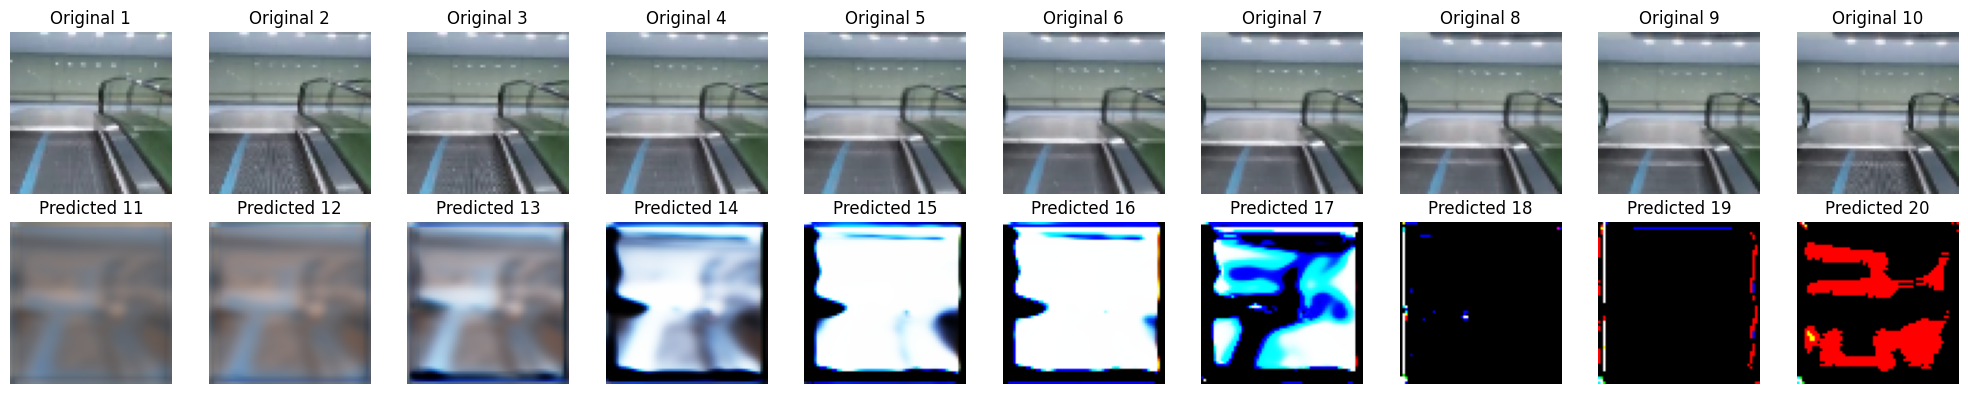

Predicted video saved to predicted_video.mp4


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Visualize predictions
example_idx = np.random.choice(range(len(x_val)), size=1)[0]
example = x_val[example_idx]  # Select a random example from x_val
original_frames = y_val[example_idx]  # Corresponding ground truth frames

# Generate predicted frames
frames = example.copy()  # Start with the selected example
predicted_frames = []

for _ in range(10):  # Predict 10 future frames
    new_prediction = model.predict(np.expand_dims(frames, axis=0))  # Use trained model
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)  # Extract the last predicted frame
    frames = np.concatenate((frames, predicted_frame), axis=0)  # Append to the sequence
    predicted_frames.append(predicted_frame[0])  # Save the predicted frame

# Convert predictions to numpy array
predicted_frames = np.array(predicted_frames)

# Plot original and predicted frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames
for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Original {idx + 1}")
    ax.axis("off")

# Plot the predicted frames
for idx, ax in enumerate(axes[1]):
    ax.imshow(predicted_frames[idx])
    ax.set_title(f"Predicted {idx + 11}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Save predicted frames as a video
output_path = "predicted_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
frame_size = predicted_frames.shape[1:3][::-1]  # Extract height and width for video
video_writer = cv2.VideoWriter(output_path, fourcc, 5, frame_size)

# Write each predicted frame to the video file
for frame in (predicted_frames * 255).astype(np.uint8):  # Scale frames to 0-255
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV

video_writer.release()
print(f"Predicted video saved to {output_path}")


In [1]:
print("hello")

hello
